In [9]:
import os
import pathlib
from itertools import chain

import cv2
import numpy
import pandas
import pyarrow
from matplotlib import image
from matplotlib import pyplot

In [10]:
data_root = pathlib.Path(os.curdir).resolve().parent.joinpath("data")
data_root.mkdir(exist_ok=True)
flag_path = data_root.parent.joinpath("welsh-dragon.jpg")
out_path = data_root.joinpath("welsh-dragon.arrow")

In [3]:
flag: numpy.ndarray = image.imread(flag_path)
flag = flag.astype(numpy.float32) / 255
flag = 1 - flag
(x, y, c) = flag.shape
padding = (y - x) // 2
flag = numpy.pad(flag, ((padding, padding), (0, 0), (0, 0)), constant_values=0)
flag = cv2.resize(flag, (1024, 1024), interpolation = cv2.INTER_LINEAR)
flag = cv2.cvtColor(flag, cv2.COLOR_BGR2GRAY)

In [4]:
print(flag.shape, flag.dtype)

(1024, 1024) float32


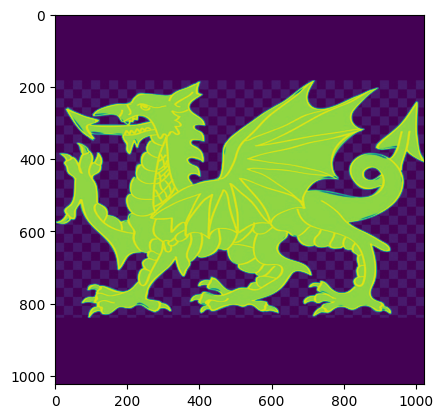

In [5]:
pyplot.imshow(flag)
pyplot.show()

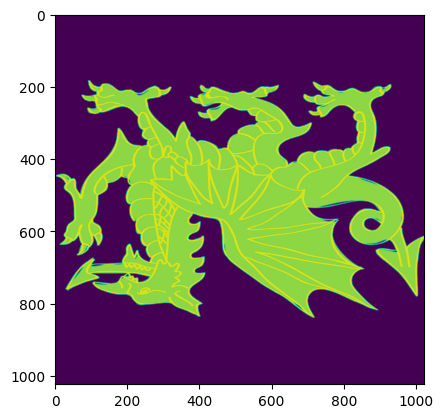

In [6]:
red_mask = flag[:, :] < 0.25
red = flag[:, :]
red[red_mask] = 0

max_val = red.max()
red = ((red / max_val) * 255).astype(numpy.uint8)
red = numpy.flip(red, axis=0)
pyplot.imshow(red)
pyplot.show()

In [7]:
(x_c, y_c) = red.shape
(x_c, y_c) = (x_c // 2, y_c // 2)

In [8]:
pairs = [
    [(x - x_c, y - y_c)] * red[x, y]
    for x in range(red.shape[0])
    for y in range(red.shape[1])
]
pairs = list(chain(*pairs))

In [15]:
df = pandas.DataFrame(pairs, columns=["x", "y"], dtype=numpy.int16)
df = df.sample(frac=1).reset_index(drop=True)

schema = pyarrow.Schema.from_pandas(df, preserve_index=False)
table = pyarrow.Table.from_pandas(df, preserve_index=False)
writer = pyarrow.ipc.new_file(str(out_path), schema)
writer.write(table)
writer.close()

In [16]:
df.head()

,x,y
0,-284,-76
1,-131,378
2,275,-226
3,287,-119
4,-45,294


In [17]:
df.describe()

,x,y
count,7.755001e+07,7.755001e+07
mean,3.384318e+00,-3.434318e+00
std,1.587349e+02,2.464334e+02
min,-3.290000e+02,-5.120000e+02
25%,-1.110000e+02,-2.120000e+02
50%,4.000000e+00,9.000000e+00
75%,1.330000e+02,1.930000e+02
max,3.280000e+02,5.110000e+02


In [18]:
df.dtypes

x    int16
y    int16
dtype: object